# Importing Libraries

In [2]:
# %pip install PyPortfolioOpt

In [4]:
# %pip install yfinance

In [6]:
# %pip install fredapi

In [7]:
import pandas as pd
import numpy as np
import yfinance as yf
from fredapi import Fred
import datetime
import time
import requests
import io
import statsmodels.api as sm
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

# 1. Data Importing

The time period for analysis is from January 1, 2014 to December 31, 2020. 

In [9]:
start = datetime.datetime(2018,1,1)
end = datetime.datetime(2020,12,31)

## 1.1 Downlaoding SPDR ETFs and 

For the purpose of this project we focus on "Close" prices. 

In [10]:
# Creating a DataFrame of SPDR ETF Prices

spdr_etf_lst = ['XLK', 'XLF', 'XLU', 'XLP', 'XLV', 'XLRE', 'XLE', 'XLY', 'XLB', 'XLC', 'XLI']

aux_ = yf.download(spdr_etf_lst[0], start=start, end=end, progress=False)
spdr_etf_price = aux_.Close.rename(spdr_etf_lst[0]).to_frame()
for tkr in spdr_etf_lst[1:]:
    aux_ = yf.download(tkr, start=start, end=end, progress=False)
    spdr_etf_price = pd.concat([spdr_etf_price, aux_.Close.rename(tkr).to_frame()], axis = 1)    

In [11]:
spdr_etf_price.shape

(755, 11)

In [12]:
spdr_etf_price

,XLK,XLF,XLU,XLP,XLV,XLRE,XLE,XLY,XLB,XLC,XLI
Date,,,,,,,,,,,
2018-01-02,64.739998,27.920000,52.189999,56.540001,83.610001,32.750000,73.449997,100.190002,61.389999,NaN,76.120003
2018-01-03,65.279999,28.070000,51.779999,56.520000,84.410004,32.759998,74.550003,100.650002,61.820000,NaN,76.529999
2018-01-04,65.610001,28.330000,51.349998,56.680000,84.529999,32.200001,75.000000,100.980003,62.360001,NaN,77.089996
2018-01-05,66.300003,28.410000,51.330002,56.930000,85.250000,32.270000,74.970001,101.779999,62.860001,NaN,77.620003
2018-01-08,66.550003,28.370001,51.810001,57.070000,84.940002,32.490002,75.419998,101.900002,62.950001,NaN,77.940002
...,...,...,...,...,...,...,...,...,...,...,...
2020-12-23,128.210007,28.910000,60.779999,66.389999,111.150002,35.560001,38.320000,157.550003,71.129997,66.190002,87.989998
2020-12-24,129.059998,28.950001,61.209999,66.720001,111.470001,35.910000,38.119999,157.880005,71.580002,66.260002,88.000000
2020-12-28,130.520004,29.090000,61.480000,67.250000,111.750000,36.200001,37.880001,159.679993,71.300003,67.449997,88.110001


In the function below we are trying to select the first trading dates in each month. Since the returns are daily and the economic leading index values are reported monthly, we should have the monthly dates for which there is a value for returns and index values. That is what the block below is trying to accomplish. 

In [13]:
def to_monthly(df0, start=start, end=end):
    """
    Argument:
        df: the dataframe whose index is going to be standardized to monthly format
        start: start date
        end: end date
        
    Returns:
        a dataframe with monthy index   
    
    """
    df = df0.copy()
    df.index = df.index.to_period('M')

    dates_monthly = pd.date_range(start,end,freq='m').to_period('M')

    aux_df = pd.DataFrame([]*len(dates_monthly), index = dates_monthly, columns = df.columns) 

    for i in range(len(dates_monthly)):
        d1 = aux_df.index[i]

        if d1 in df.index:
            aux_df.loc[d1,] = df[df.index == d1].iloc[-1]   #.loc[d1,:].iloc[0,:]
        else:
            aux_df.loc[d1,] = aux_df.loc[ aux_df.index[i-1], : ]
            
    return(aux_df)

# 2. Data Processing

## 2.1 Form Portfolio

#### We select Technology and Healthcare ETFs. Namely: XLK and XLF. We use 100 shares of each. 
#### To form an equally weighted portfolio of the above ETFs, we assume we have 100 million dollar asset under management. Thus 50 million dollar will be allocated to XLK and 50 million dollar will be allocated to XLV. For the sake of simplicity we assume that a fraction of number of ETFs is available to purchase. 

In [14]:
n_xlk = (50000000)/spdr_etf_price['XLK'][0]
n_xlv = (50000000)/spdr_etf_price['XLV'][0]


In [15]:
print( f' - Number of XLK ETFs = {n_xlk}')
print( f' - Number of XLV ETFs = {n_xlv}')

 - Number of XLK ETFs = 772320.0749127846
 - Number of XLV ETFs = 598014.5871905377


## 2.2 Standard Deviations

In [16]:
# Calculating Daily Returns of SPDR ETFs
#spdr_etf_price = to_monthly(spdr_etf_price)
spdr_etf_rtns = spdr_etf_price.pct_change(1).iloc[1:,:]

In [17]:
spdr_etf_price.head()

,XLK,XLF,XLU,XLP,XLV,XLRE,XLE,XLY,XLB,XLC,XLI
Date,,,,,,,,,,,
2018-01-02,64.739998,27.920000,52.189999,56.540001,83.610001,32.750000,73.449997,100.190002,61.389999,NaN,76.120003
2018-01-03,65.279999,28.070000,51.779999,56.520000,84.410004,32.759998,74.550003,100.650002,61.820000,NaN,76.529999
2018-01-04,65.610001,28.330000,51.349998,56.680000,84.529999,32.200001,75.000000,100.980003,62.360001,NaN,77.089996
2018-01-05,66.300003,28.410000,51.330002,56.930000,85.250000,32.270000,74.970001,101.779999,62.860001,NaN,77.620003
2018-01-08,66.550003,28.370001,51.810001,57.070000,84.940002,32.490002,75.419998,101.900002,62.950001,NaN,77.940002


In [18]:
spdr_etf_rtns.head()

,XLK,XLF,XLU,XLP,XLV,XLRE,XLE,XLY,XLB,XLC,XLI
Date,,,,,,,,,,,
2018-01-03,0.008341,0.005372,-0.007856,-0.000354,0.009568,0.000305,0.014976,0.004591,0.007004,NaN,0.005386
2018-01-04,0.005055,0.009263,-0.008304,0.002831,0.001422,-0.017094,0.006036,0.003279,0.008735,NaN,0.007317
2018-01-05,0.010517,0.002824,-0.000389,0.004411,0.008518,0.002174,-0.000400,0.007922,0.008018,NaN,0.006875
2018-01-08,0.003771,-0.001408,0.009351,0.002459,-0.003636,0.006818,0.006002,0.001179,0.001432,NaN,0.004123
2018-01-09,-0.002555,0.007755,-0.009844,-0.001402,0.011773,-0.011388,-0.002519,0.001963,-0.001589,NaN,0.006415


In [19]:
spdr_etf_std = spdr_etf_rtns.std()

print( f' - Standard Deviation of XLK = {spdr_etf_std.XLK}')
print( f' - Standard Deviation of XLV = {spdr_etf_std.XLV}')

 - Standard Deviation of XLK = 0.018166580507840743
 - Standard Deviation of XLV = 0.013719648573235621


## 2.3 Correlations b/w Securities

In [20]:
corr_xlk_xlv = spdr_etf_rtns[['XLK','XLV']].corr()

In [21]:
# coorelation of XLK and XLV
corr_xlk_xlv

,XLK,XLV
XLK,1.000000,0.829307
XLV,0.829307,1.000000


## 2.4 Weighted Return of a Portfolio

In [22]:
def weighted_return(return_vector1, return_vector2, w1, w2):
    return w1*return_vector1+w2*return_vector2

In [23]:
weighted_return(spdr_etf_rtns['XLK'], spdr_etf_rtns['XLV'], n_xlk, n_xlv)

Date
2018-01-03    12163.941513
2018-01-04     4754.335639
2018-01-05    13215.988312
2018-01-08      737.635970
2018-01-09     5067.499337
                  ...     
2020-12-23    -5427.843435
2020-12-24     6841.909865
2020-12-28    10239.101818
2020-12-29     -832.544375
2020-12-30     -522.641778
Length: 754, dtype: float64

## 2.5 Portfolio Standard Deviation 

In [24]:
def weighted_std(vol1, vol2, corr, w1, w2):
    ptf_std = np.sqrt(w1**2*vol1**2+w2**2*vol2**2+2*w1*w2*corr*vol1*vol2)
    
    return ptf_std

In [25]:
weighted_std(spdr_etf_std.XLK, spdr_etf_std.XLV, corr_xlk_xlv.loc['XLK','XLV'], n_xlk, n_xlv)

21332.9715221551

# 3. Category 1 Portfolio: 2 Sectors

## 3.1 Function for Efficient Frontiers

In [26]:
def trim_series(ret1, ret2, alpha):
    """ trims two Panda series by alpha percent
    returns series trimmed and only that portion for which ret1 and ret2 maintain index overlap
    
    Returns:
        - ret1 and ret2: series trimmed with fully overlapped index
    """

    alpha = alpha/100

    i1 = int(round(alpha*len(ret1),0))
    
    r1 = ret1.sort_values()[i1:-(i1+1)]

    r2 = ret2.sort_values()[i1:-(i1+1)]

    indx = r1.index[r1.index.isin(r2.index)].sort_values()
    
    r1 = ret1.loc[indx]
    r2 = ret2.loc[indx]

    return r1, r2

In [27]:
def ptf_return_vol(price_vector1, price_vector2, w1, w2, start_date, end_date, correlation = 'not passed', alpha=0):
    """
    This function calculates the return and annualized volatility of a portfolio of two assets over a given period of time
    
    Arguments:
        - price_vector1, price_vector2: DAILY price vectors for assets 1 and 2
        - w1, w2: normalized weights of each assets expressed in terms of a number from 0 to 1
        - start_date, end_date: the start and end dates of the period for which we conduct the analysis
        - correlation: a value can be passed. If not passed it will be calculated from daily return vectors.
        
    Returns:
        - return:  over the given period in %
        - volatility: volatility over the given period of time (annualized) in %
    """
    
    ### Calculating the Portfolio Returns
    indx_ = np.logical_and( price_vector1.index > start_date, price_vector1.index < end_date)
    
    price1 = price_vector1[indx_]
    price2 = price_vector2[indx_]

    daily_rtns1 = price1.pct_change(1)[1:]
    daily_rtns2 = price2.pct_change(1)[1:]

    return_1 = np.sqrt((daily_rtns1+1).prod())**(365/(end_date-start_date).days)
    return_2 = np.sqrt((daily_rtns2+1).prod())**(365/(end_date-start_date).days)

    #return_1 = price1[-1]/price1[0] - 1
    #return_2 = price2[-1]/price1[0] - 1
    
    ptf_return = w1*return_1 + w2*return_2
    
    
    ### Calculating the Portfolio Volatility
    #daily_rtns1 = price1.pct_change(1)[1:]
    #daily_rtns2 = price2.pct_change(1)[1:]
    
    # Here we trim the returns by alpha% if needed
    if alpha != 0:
        daily_rtns1, daily_rtns2 = trim_series(daily_rtns1, daily_rtns2, alpha) 
        
        
    if correlation == 'not passed':
        correlation = np.corrcoef(daily_rtns1, daily_rtns2)[0,1]
        
    std1 = daily_rtns1.std()
    std2 = daily_rtns2.std()
    #print(f' First Volatility = {std1}')
    #print(f' Second Volatility = {std2}')
    #print(f' Correlation = {correlation}')

        
    ptf_daily_vol = weighted_std(std1, std2, correlation, w1, w2)
    ptf_annual_vol = ptf_daily_vol*np.sqrt(250)
    
    ptf_annual_vol_normalized = ptf_annual_vol/ptf_return
    
    return ptf_return*100, ptf_annual_vol_normalized*100

In [28]:
def efficient_frontier_2d(price_vector1, price_vector2, start_date, end_date, correlation = 'not passed', alpha=0):
    

    weights = np.linspace(0,1,101)
    
    ptf_returns = [0]*len(weights)
    ptf_vol = [0]*len(weights)

    for i in range(len(weights)):
        ptf_returns[i], ptf_vol[i] = ptf_return_vol(price_vector1, price_vector2, weights[i], 1-weights[i], start_date, end_date, correlation, alpha)
        
    return ptf_returns, ptf_vol

In [29]:
start_date = datetime.datetime(2018,1,1)
end_date = datetime.datetime(2020,12,31)

price_vec1 = spdr_etf_price['XLK']
price_vec2 = spdr_etf_price['XLV']

ptf_returns1, ptf_vol1 = efficient_frontier_2d(price_vec1, price_vec2, start_date, end_date)

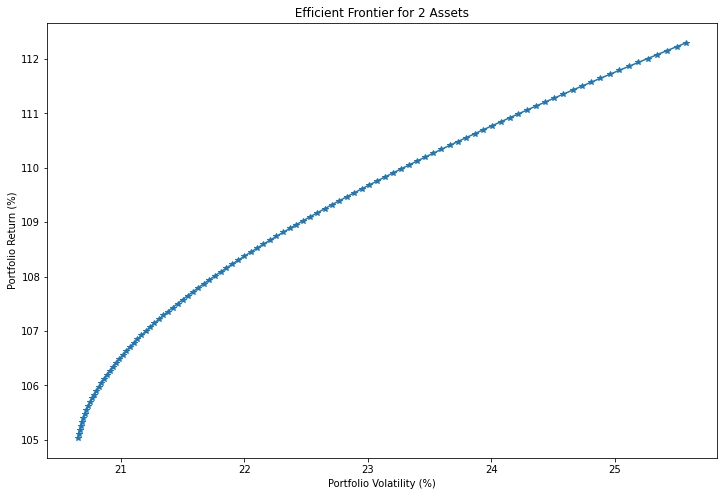

In [30]:
plt.figure(figsize = (12,8))

plt.plot(ptf_vol1, ptf_returns1, marker = '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(' Efficient Frontier for 2 Assets ')

plt.show()

## 3.2
#### The leftmost porfolio is called the global minimum variance portfolio.  It is the portfolio with the smallest volatility possible that can be created from the two assets in qustion. 

## 3.3 Correlation = 1

In [31]:
correlation = 1
ptf_returns2, ptf_vol2 = efficient_frontier_2d(price_vec1, price_vec2, start_date, end_date, correlation)

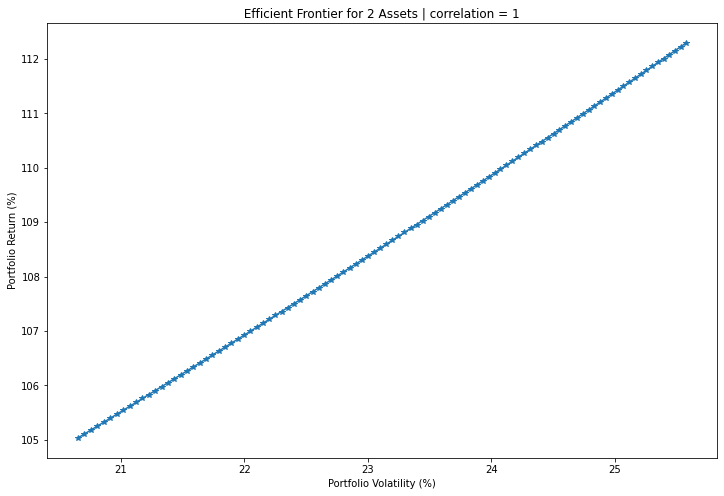

In [32]:
plt.figure(figsize = (12,8))

plt.plot(ptf_vol2, ptf_returns2, marker = '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(f' Efficient Frontier for 2 Assets | correlation = {correlation} ')

plt.show()

#### In this case, since the assets are perfectly correlated, increasing the weight of assets 2 (XLV) reduces the portfolio volatility. We showed above that the volatility of second asset (XLV) is smaller than the volatility of first asset (XLK). So as its weight goes up the portfolio volatility goes down. Also in this case, the curve shape of the efficient frontier disappears. 

## 3.4 Correlation = 0

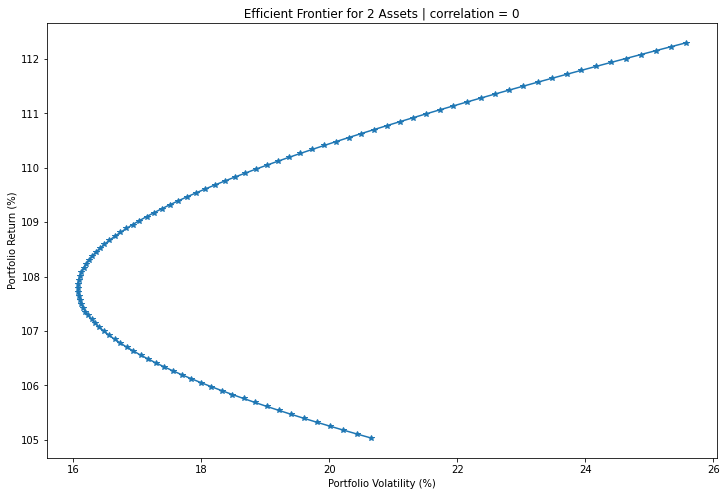

In [33]:
correlation = 0
ptf_returns3, ptf_vol3 = efficient_frontier_2d(price_vec1, price_vec2, start_date, end_date, correlation)

plt.figure(figsize = (12,8))

plt.plot(ptf_vol3, ptf_returns3, marker = '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(f' Efficient Frontier for 2 Assets | correlation = {correlation} ')

plt.show()

#### With removing correlation between the assets the positivive impact of diversification started to kick in. Now for the same amount of volatilities, we can observe higher returns or we can obtain the same amount of return with much lower voaltilities.The volatility of the portfolio with minimum volatility is much smaller than the case with correlation = 1.

## 3.5 Correlation = -1

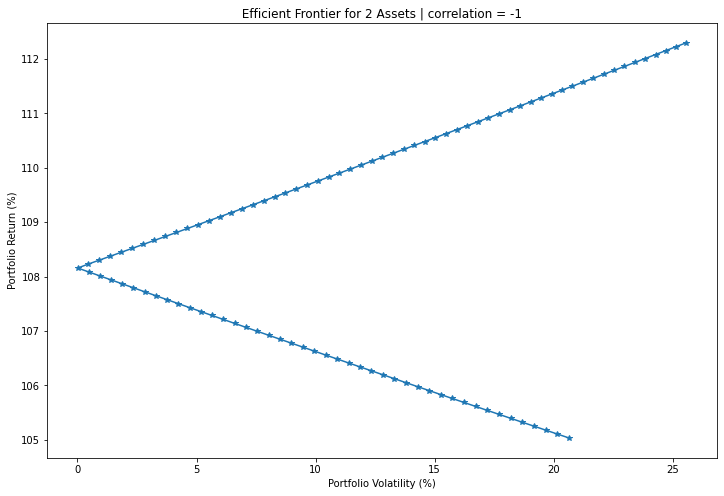

In [34]:
correlation = -1
ptf_returns4, ptf_vol4 = efficient_frontier_2d(price_vec1, price_vec2, start_date, end_date, correlation)

plt.figure(figsize = (12,8))

plt.plot(ptf_vol4, ptf_returns4, marker = '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(f' Efficient Frontier for 2 Assets | correlation = {correlation} ')

plt.show()

#### As it can be seen in this case the volatilities are significantly lower than the case with correlation = 0 or correlation = 1. Basically the volatility of the leftmost portfolio is around 2% which is significantly lower than the one with the case of correlation = 0. In the case with correlation = 0, the volatility of leftomost portfolio was about 20%. Note that the returns in these two cases are practically the same. 

#### So we take advantage of diversification in this case the most, and we are able to obtain the same return with much smaller risk and volatilities. 

## 3.6 Trimmed Data

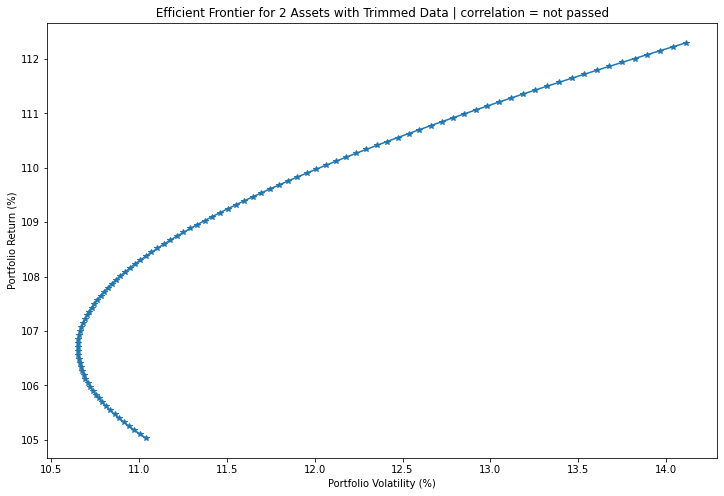

In [35]:
correlation = 'not passed'
alpha = 5

ptf_returns5, ptf_vol5 = efficient_frontier_2d(price_vec1, price_vec2, start_date, end_date, correlation, alpha)

plt.figure(figsize = (12,8))

plt.plot(ptf_vol5, ptf_returns5, marker = '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(f' Efficient Frontier for 2 Assets with Trimmed Data | correlation = {correlation} ')

plt.show()

## 3.7 EF of Trimmed Data vs. EF of Actual Data
#### It is very clear to see that the whole curve has moved to the left. Meaning the same level of returns can be obtained with smaller volatilities. Trimming the data (removing outliers and too large and too small values) reduced standard deviation i.e. volatility, thereby reducing the calculated risk (vol) of portfolio.

## 3.8 Robust Method of Portfolio Analysis

In [36]:
start_date = datetime.datetime(2018,1,1)
end_date = datetime.datetime(2020,12,31)

price_df = spdr_etf_price[['XLK', 'XLV']].loc[start_date:end_date]

mu = expected_returns.mean_historical_return(price_df)
S = risk_models.sample_cov(price_df)

ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()

ptf_performance = ef.portfolio_performance(verbose=True)



Expected annual return: 26.2%
Annual volatility: 28.8%
Sharpe Ratio: 0.84


## 3.9 
#### The methodology used here is based on maximizing the Sharpe Ratio of the portfolio. The state variables are portfolio weights (w1 and w2). Bascially the algorithm here is to find w1 and w2 such that the maximum Sharpe Ration is achieved. This would be a portfolio that deliveres the highest return for each unit of volatility. 

The equations are as follows:


maximize Sharpe Ratio = (Portfolio Return - Risk Free Rate)/(Portfolio Volatility)

Subjected to:


w1, w2 >= 0

w1 + w2 = 1.0




## 3.10
#### Using maximizing the Sharpe Ratio, we get the same return but for much lower volatility when compared with method 1, where we used simple mean-variance optimization

#### When compared with the trimmed data, this approach provides about the same return for much lower volatility 

#### Thus using minimzing the Sharpe Ratio we can obtain the best Sharpe Ratio compared with method 1 (mean-var optimization) and method 2 (using trimmed data). 

# 4. Category 2 Portfolio: 3 Sectors

#### Now we can add XLU to the mix of previous two portfolios.

### 4.1 Correlation Matrix

In [37]:
corr_3d = spdr_etf_rtns[['XLK', 'XLV', 'XLU']].loc[start_date:end_date].corr()

corr_3d

,XLK,XLV,XLU
XLK,1.000000,0.829307,0.562165
XLV,0.829307,1.000000,0.673268
XLU,0.562165,0.673268,1.000000


In [38]:
cov_3d = spdr_etf_rtns[['XLK', 'XLV', 'XLU']].loc[start_date:end_date].cov()

cov_3d

,XLK,XLV,XLU
XLK,0.000330,0.000207,0.000160
XLV,0.000207,0.000188,0.000145
XLU,0.000160,0.000145,0.000246


## 4.2 The Efficient Frontier

In [39]:
weights = np.linspace(0,1,11)

price_vec1 = spdr_etf_price['XLK'].loc[start_date:end_date]
price_vec2 = spdr_etf_price['XLV'].loc[start_date:end_date]
price_vec3 = spdr_etf_price['XLU'].loc[start_date:end_date]

ptf_returns6 = [0]*60
ptf_vol6 = [0]*60
i = 0;

for w1 in weights:
    for w2 in np.linspace(0, (1-w1), int((1-w1)/0.10+1)):
        w3 = 1 - w1 - w2
        #print(w1, w2, w3)
        
        ptf_returns_vec = w1*spdr_etf_rtns['XLK']+w2*spdr_etf_rtns['XLV']+w3*spdr_etf_rtns['XLU']
        
        #print(ptf_returns_vec.shape)
        
        ret1 = price_vec1[-1]/price_vec1[0]-1
        ret2 = price_vec2[-1]/price_vec2[0]-1
        ret3 = price_vec3[-1]/price_vec3[0]-1
        
        ptf_return = w1*ret1+w2*ret2+w3*ret3
        ptf_vol = ptf_returns_vec.std()*np.sqrt(250)/np.abs(ptf_return)
        
        #print(ptf_return)
        #print(ptf_vol)
        
        ptf_returns6[i] = ptf_return*100
        ptf_vol6[i] = ptf_vol*100
        i = i + 1
        #print(w1,w2,w3,ptf_return, ptf_vol)

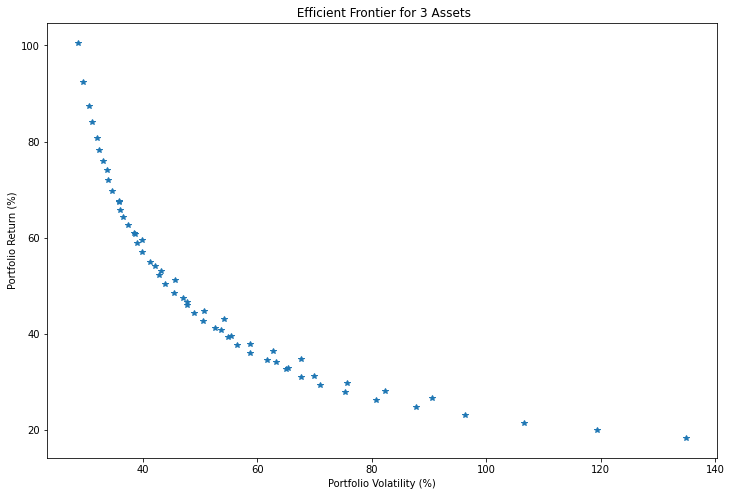

In [40]:
plt.figure(figsize = (12,8))

plt.plot(ptf_vol6, ptf_returns6, '*')
plt.ylabel('Portfolio Return (%)')
plt.xlabel('Portfolio Volatility (%)')
plt.title(f' Efficient Frontier for 3 Assets')

plt.show()

## 4.3 
#### Adding one more ETFs has benefited us. Because if we look at the returns, the returns have increased dramatically. Especially that the leftmost point indicates that return of around 100% is obtained with a volatility of around 28%. If we compare that with the leftmost point on efficient frontier with two assets, we were obtaining about 85% with the same amount of volatility. Ofcourse in general whether diversification benefit us or not depend on the correlation matrix of the assets involved. 

# 5. Category 3 Portfolio: All Combinations

## 5.1 Efficient Frontiers for 3 Portfolios

In [45]:
# Generating the Combinations
from itertools import combinations

def optimal_portfolios(price_df, selected_risk):
    comb = combinations(price_df.columns, 3)
    comb_lst = list(comb)
    n_combinations = len(comb_lst)
    print(n_combinations)

    # We use the selected risk of portfolio to be 35%
    counter = 0;

    cols = ['Asset_1', 'Asset_2', 'Asset_3', 'Weight_1', 'Weight_2', 'Weight_3', 'Expected_Return', 'Annual_Volatility', 'Sharpe_Ratio']
    optimal_portfolios_lst = pd.DataFrame([ [0]*len(cols) ]*n_combinations, columns=cols)

    for ptf0 in comb_lst:
        #print(ptf0)
        ptf = list(ptf0)

        price_ptf = price_df[ptf]

        mu = expected_returns.mean_historical_return(price_ptf)
        S = risk_models.sample_cov(price_ptf)

        ef = EfficientFrontier(mu, S, weight_bounds=(-1, 1))
        raw_weights = ef.efficient_risk(target_volatility=selected_risk)

        ptf_performance = ef.portfolio_performance(verbose=False)

        optimal_portfolios_lst.iloc[counter,:3] = ptf
        optimal_portfolios_lst.iloc[counter,3:6] = [raw_weights[ptf[0]], raw_weights[ptf[1]], raw_weights[ptf[2]]]
        optimal_portfolios_lst.iloc[counter,6:] = list(ptf_performance)

        counter = counter + 1

    return optimal_portfolios_lst

## 5.2 & 5.3 Running and Ranking 2019 Portfolios

In [46]:
start_date = datetime.datetime(2019,1,1)
end_date = datetime.datetime(2019,12,31)

etf_price_2019 = spdr_etf_price.loc[start_date:end_date]

# Selected Risk for Portfolio is 40%
selected_risk = 0.40

optimal_ptf_2019 = optimal_portfolios(etf_price_2019, selected_risk)

165


We rank the 2019 optimal portfolios by Sharpe Ration.

In [47]:
optimal_ptf_2019.sort_values('Sharpe_Ratio', ascending=False)

,Asset_1,Asset_2,Asset_3,Weight_1,Weight_2,Weight_3,Expected_Return,Annual_Volatility,Sharpe_Ratio
19,XLK,XLP,XLE,1.0,1.0,-1.0,0.702314,0.218367,3.124615
10,XLK,XLU,XLV,1.0,1.0,-1.0,0.527512,0.162836,3.116709
4,XLK,XLF,XLE,1.0,1.0,-1.0,0.736290,0.231848,3.089477
30,XLK,XLRE,XLE,1.0,1.0,-1.0,0.731493,0.230777,3.083030
12,XLK,XLU,XLE,1.0,1.0,-1.0,0.697119,0.219647,3.082766
...,...,...,...,...,...,...,...,...,...
69,XLF,XLRE,XLC,1.0,-1.0,1.0,0.288161,0.279337,0.959991
104,XLU,XLY,XLC,-1.0,1.0,1.0,0.298200,0.289907,0.959617
108,XLU,XLC,XLI,-1.0,1.0,1.0,0.299407,0.295052,0.946974
52,XLF,XLU,XLI,1.0,-1.0,1.0,0.298742,0.308643,0.903120


## 5.4 EF using 2020 Data

In [48]:
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2020,12,31)

etf_price_2020 = spdr_etf_price.loc[start_date:end_date]

# Selected Risk for Portfolio is 40%
selected_risk = 0.40

optimal_ptf_2020 = optimal_portfolios(etf_price_2020, selected_risk)

165


## 5.5 Ranking 2020 Portfolios

In [49]:
optimal_ptf_2020.sort_values('Sharpe_Ratio', ascending=False)

,Asset_1,Asset_2,Asset_3,Weight_1,Weight_2,Weight_3,Expected_Return,Annual_Volatility,Sharpe_Ratio
155,XLE,XLY,XLB,-0.893584,1.000000,0.893584,0.766917,0.400000,1.867293
158,XLE,XLB,XLC,-0.866546,1.000000,0.866546,0.713030,0.400000,1.732576
35,XLK,XLE,XLY,0.582977,-0.582977,1.000000,0.711752,0.400000,1.729379
156,XLE,XLY,XLC,-0.718941,1.000000,0.718941,0.702307,0.400000,1.705768
36,XLK,XLE,XLB,0.657982,-0.657982,1.000000,0.690351,0.400000,1.675877
...,...,...,...,...,...,...,...,...,...
98,XLU,XLRE,XLI,0.935247,-0.935247,1.000000,0.083770,0.400000,0.159425
70,XLF,XLRE,XLI,-1.000000,1.000000,1.000000,0.070202,0.389433,0.128910
94,XLU,XLRE,XLE,0.689485,0.616817,-0.306302,0.057367,0.400000,0.093417
66,XLF,XLRE,XLE,0.403404,0.850807,-0.254212,0.021657,0.400000,0.004141


The Sharpe Ratios for 2019 are higher. One reason could be that volatility of portfolios in 2019 were lower. 2020 was a year of higher volatility. 

# 6 Analyzing 3 Security Portfolios

In [50]:
fred = Fred(api_key='b92c78112636e691a41a2398f567d4bc')

In [51]:
econ_indic_tckrs = ['AWHMAN', 'ICSA', 'ACDGNO', 'NEWORDER', 'UNXANO', 'PERMIT1', 'SP500', 'NFCINONFINLEVERAGE', 'T10YFF', 'UMCSENT', 
                    'PAYEMS', 'W875RX1', 'INDPRO', 'CMRMTSPL', 
                    'MNFCTRIRSA', 'UEMPMEAN', 'TOTALSL','BUSLOANS', 'DPRIME', 'ULCMFG', 'CUSR0000SASLE']

lei_indc = econ_indic_tckrs[:10]
cei_indc = econ_indic_tckrs[10:14]
lag_indc = econ_indic_tckrs[14:]

In [52]:
economic_indicators = to_monthly(pd.DataFrame(fred.get_series('AWHMAN'), columns = ['AWHMAN']).loc[start:end,:])

for tkr in econ_indic_tckrs[1:]:  
    economic_indicators =  pd.concat([economic_indicators, to_monthly(pd.DataFrame(fred.get_series(tkr), columns = [tkr]).loc[start:end,:])], axis = 1)

In [53]:
economic_indicators = economic_indicators.fillna(0)

In [55]:
econ_indic_tckrs = ['AWHMAN', 'ICSA', 'ACDGNO', 'NEWORDER', 'UNXANO', 'PERMIT1', 'SP500', 'NFCINONFINLEVERAGE', 'T10YFF', 'UMCSENT', 
                    'PAYEMS', 'W875RX1', 'INDPRO', 'CMRMTSPL', 
                    'MNFCTRIRSA', 'UEMPMEAN', 'TOTALSL','BUSLOANS', 'DPRIME', 'ULCMFG', 'CUSR0000SASLE']

lei_indc = econ_indic_tckrs[:10]
cei_indc = econ_indic_tckrs[10:14]
lag_indc = econ_indic_tckrs[14:]

In [56]:
lei = economic_indicators[lei_indc]
cei = economic_indicators[cei_indc]
lag = economic_indicators[lag_indc]

In [57]:
def run_linreg(X_df, Y_df):
    
    n_rows = len(Y_df.columns)

    coefficient_matrix = pd.DataFrame([], index = Y_df.columns, columns = X_df.columns)
    tstat_matrix = pd.DataFrame([], index = Y_df.columns, columns = X_df.columns)
    r_squared = pd.DataFrame([0]*n_rows, index = Y_df.columns, columns = ['Adjusted_R_Squared'] )

    for tckr in Y_df.columns:
        X0 = X_df[ ~Y_df[tckr].isnull() ]
        X = sm.add_constant(X0).astype(float)
        
        y = Y_df[tckr][ ~Y_df[tckr].isnull() ].astype(float)
    
        linreg = sm.OLS(y, X)
        linreg2 = linreg.fit()
        
        coefficient_matrix.loc[tckr,:] = linreg2.params[1:]
        r_squared.loc[tckr,:] = linreg2.rsquared_adj
        tstat_matrix.loc[tckr,:] = linreg2.tvalues[1:]
       
    return(tstat_matrix, coefficient_matrix, r_squared)

In [58]:
month_return = to_monthly(spdr_etf_rtns)
month_return = month_return.fillna(month_return.mean())

In [59]:
def best_fit(groups, returns):
    table = {}

    table['ETF']= returns.columns
    
    A=[lei, cei, lag]

    for i in range(len(groups)):
        _, _, adjusted_r_square = run_linreg(A[i], returns)
        table[groups[i]] = adjusted_r_square['Adjusted_R_Squared'].to_list()

    return pd.DataFrame(table)

In [60]:
B= ['lei_r_squared', 'cei_r_squared', 'lag_r_squared']

Best_corr = best_fit(B, month_return)

C:\Users\huomi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\huomi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\huomi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\Users\huomi\AppData\Local\Packa

In [61]:
Best_corr['groups'] = Best_corr[['lei_r_squared', 'cei_r_squared', 'lag_r_squared']].idxmax(axis=1)

In [62]:
best_comb = optimal_ptf_2020.sort_values('Sharpe_Ratio', ascending=False)
best_comb

,Asset_1,Asset_2,Asset_3,Weight_1,Weight_2,Weight_3,Expected_Return,Annual_Volatility,Sharpe_Ratio
155,XLE,XLY,XLB,-0.893584,1.000000,0.893584,0.766917,0.400000,1.867293
158,XLE,XLB,XLC,-0.866546,1.000000,0.866546,0.713030,0.400000,1.732576
35,XLK,XLE,XLY,0.582977,-0.582977,1.000000,0.711752,0.400000,1.729379
156,XLE,XLY,XLC,-0.718941,1.000000,0.718941,0.702307,0.400000,1.705768
36,XLK,XLE,XLB,0.657982,-0.657982,1.000000,0.690351,0.400000,1.675877
...,...,...,...,...,...,...,...,...,...
98,XLU,XLRE,XLI,0.935247,-0.935247,1.000000,0.083770,0.400000,0.159425
70,XLF,XLRE,XLI,-1.000000,1.000000,1.000000,0.070202,0.389433,0.128910
94,XLU,XLRE,XLE,0.689485,0.616817,-0.306302,0.057367,0.400000,0.093417
66,XLF,XLRE,XLE,0.403404,0.850807,-0.254212,0.021657,0.400000,0.004141


In [63]:
best_comb_ind = best_comb.replace(Best_corr.iloc[:,0].to_list(), Best_corr.iloc[:,4].to_list())
best_comb_ind

,Asset_1,Asset_2,Asset_3,Weight_1,Weight_2,Weight_3,Expected_Return,Annual_Volatility,Sharpe_Ratio
155,lei_r_squared,lei_r_squared,lei_r_squared,-0.893584,1.000000,0.893584,0.766917,0.400000,1.867293
158,lei_r_squared,lei_r_squared,lei_r_squared,-0.866546,1.000000,0.866546,0.713030,0.400000,1.732576
35,lei_r_squared,lei_r_squared,lei_r_squared,0.582977,-0.582977,1.000000,0.711752,0.400000,1.729379
156,lei_r_squared,lei_r_squared,lei_r_squared,-0.718941,1.000000,0.718941,0.702307,0.400000,1.705768
36,lei_r_squared,lei_r_squared,lei_r_squared,0.657982,-0.657982,1.000000,0.690351,0.400000,1.675877
...,...,...,...,...,...,...,...,...,...
98,lag_r_squared,lei_r_squared,lei_r_squared,0.935247,-0.935247,1.000000,0.083770,0.400000,0.159425
70,lei_r_squared,lei_r_squared,lei_r_squared,-1.000000,1.000000,1.000000,0.070202,0.389433,0.128910
94,lag_r_squared,lei_r_squared,lei_r_squared,0.689485,0.616817,-0.306302,0.057367,0.400000,0.093417
66,lei_r_squared,lei_r_squared,lei_r_squared,0.403404,0.850807,-0.254212,0.021657,0.400000,0.004141


In [64]:
best_comb_ind = best_comb_ind.reset_index()

In [65]:

for j in range(3):
    A = []
    for i in range(len(best_comb_ind)):
        if best_comb_ind.loc[i][j+4]>0:
            A.append('+' + best_comb_ind.loc[i][j+1])
        else:
            A.append('-' + best_comb_ind.loc[i][j+1] ) 
    best_comb_ind[best_comb_ind.columns[j+1]]=A


In [66]:
# best combination of indicator groups
best_comb_ind


,index,Asset_1,Asset_2,Asset_3,Weight_1,Weight_2,Weight_3,Expected_Return,Annual_Volatility,Sharpe_Ratio
0,155,-lei_r_squared,+lei_r_squared,+lei_r_squared,-0.893584,1.000000,0.893584,0.766917,0.400000,1.867293
1,158,-lei_r_squared,+lei_r_squared,+lei_r_squared,-0.866546,1.000000,0.866546,0.713030,0.400000,1.732576
2,35,+lei_r_squared,-lei_r_squared,+lei_r_squared,0.582977,-0.582977,1.000000,0.711752,0.400000,1.729379
3,156,-lei_r_squared,+lei_r_squared,+lei_r_squared,-0.718941,1.000000,0.718941,0.702307,0.400000,1.705768
4,36,+lei_r_squared,-lei_r_squared,+lei_r_squared,0.657982,-0.657982,1.000000,0.690351,0.400000,1.675877
...,...,...,...,...,...,...,...,...,...,...
160,98,+lag_r_squared,-lei_r_squared,+lei_r_squared,0.935247,-0.935247,1.000000,0.083770,0.400000,0.159425
161,70,-lei_r_squared,+lei_r_squared,+lei_r_squared,-1.000000,1.000000,1.000000,0.070202,0.389433,0.128910
162,94,+lag_r_squared,+lei_r_squared,-lei_r_squared,0.689485,0.616817,-0.306302,0.057367,0.400000,0.093417
163,66,+lei_r_squared,+lei_r_squared,-lei_r_squared,0.403404,0.850807,-0.254212,0.021657,0.400000,0.004141


# 7 Category 4 Portfolios: Using Principal Components

## 7.1 Correlation Matrix and PCA of Returns

In [67]:
start_date2019 = datetime.datetime(2019,1,1)
end_date2019 = datetime.datetime(2019,12,31)

rtns_corrmatrix_2019 = spdr_etf_rtns[start_date2019:end_date2019].corr()
#price_corrmatrix_2019 = spdr_etf_price[start_date:end_date].corr()

start_date2020 = datetime.datetime(2020,1,1)
end_date2020 = datetime.datetime(2020,12,31)

#price_corrmatrix_2020 = spdr_etf_price.loc[start_date:end_date]
rtns_corrmatrix_2020 = spdr_etf_rtns.loc[start_date2020:end_date2020]

In [68]:
rtns_corrmatrix_2019

,XLK,XLF,XLU,XLP,XLV,XLRE,XLE,XLY,XLB,XLC,XLI
XLK,1.000000,0.726745,0.153277,0.518123,0.675244,0.290749,0.590712,0.850911,0.704608,0.777353,0.780712
XLF,0.726745,1.000000,0.070852,0.482085,0.591860,0.156494,0.665777,0.762330,0.744374,0.626903,0.820738
XLU,0.153277,0.070852,1.000000,0.569001,0.353777,0.620372,-0.036959,0.155878,0.114079,0.163821,0.091624
XLP,0.518123,0.482085,0.569001,1.000000,0.547368,0.537786,0.293760,0.585128,0.519962,0.467626,0.502842
XLV,0.675244,0.591860,0.353777,0.547368,1.000000,0.413623,0.472324,0.638624,0.577440,0.616207,0.602151
XLRE,0.290749,0.156494,0.620372,0.537786,0.413623,1.000000,0.068020,0.336519,0.240112,0.325103,0.251186
XLE,0.590712,0.665777,-0.036959,0.293760,0.472324,0.068020,1.000000,0.602648,0.591305,0.556595,0.688924
XLY,0.850911,0.762330,0.155878,0.585128,0.638624,0.336519,0.602648,1.000000,0.720137,0.784835,0.798017
XLB,0.704608,0.744374,0.114079,0.519962,0.577440,0.240112,0.591305,0.720137,1.000000,0.541307,0.830332
XLC,0.777353,0.626903,0.163821,0.467626,0.616207,0.325103,0.556595,0.784835,0.541307,1.000000,0.638041


## 7.2 PCA Analysis of 2019 Data

In [69]:

# calculate the difference of mean and return
rt_meaned = spdr_etf_rtns[start_date2019:end_date2019] - np.mean(spdr_etf_rtns[start_date2019:end_date2019] , axis = 0)
rt_meaned 


,XLK,XLF,XLU,XLP,XLV,XLRE,XLE,XLY,XLB,XLC,XLI
Date,,,,,,,,,,,
2019-01-02,-0.000974,0.007331,-0.018014,-0.006786,-0.015827,-0.023813,0.019448,0.006597,0.004322,0.012231,0.004142
2019-01-03,-0.052087,-0.023547,-0.001011,-0.006623,-0.020989,0.003712,-0.010173,-0.022630,-0.029182,-0.017827,-0.031411
2019-01-04,0.042701,0.032154,0.013989,0.020441,0.029147,0.009277,0.033769,0.032116,0.038495,0.041942,0.036935
2019-01-07,0.007324,0.000171,-0.007641,-0.002243,0.003155,0.007548,0.014610,0.021634,0.002686,0.010329,0.007154
2019-01-08,0.006761,-0.000242,0.011584,0.008304,0.007081,0.016509,0.007480,0.010078,0.009669,0.015732,0.012721
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,-0.001290,0.001221,0.000588,0.000395,-0.001944,0.000406,-0.000739,0.001275,0.000322,-0.001278,-0.005000
2019-12-26,0.005834,0.004476,0.000898,0.000076,-0.001363,0.005133,-0.000578,0.011227,0.003593,0.006531,0.001342
2019-12-27,-0.001728,-0.003659,0.002141,0.003569,-0.000392,0.002746,-0.004453,-0.001057,-0.004571,-0.002938,-0.001835


In [70]:
# clculate eigen value and eigen vector
eig_vals, eig_vecs = np.linalg.eig(rtns_corrmatrix_2019)

In [62]:
eig_vecs

array([[ 3.53915393e-01, -8.29205229e-02, -2.67095364e-01,
        -4.86537738e-01, -2.92922316e-01, -5.61789950e-01,
         2.63184446e-01, -2.03369055e-01,  2.02925776e-01,
        -7.90007171e-02,  1.87812996e-02],
       [ 3.37426508e-01, -1.90723156e-01,  2.30991417e-01,
        -3.05977090e-01,  2.46599991e-02,  9.32754098e-02,
        -8.04682609e-01, -1.93449976e-01,  1.78798868e-02,
        -8.42577460e-02, -3.35342457e-02],
       [ 1.15486115e-01,  6.24817127e-01,  1.66737797e-01,
         6.46092251e-02,  9.21761237e-02, -2.96618133e-03,
         1.00885805e-01, -6.14750580e-01, -2.60933974e-01,
        -2.25003669e-01, -2.21305270e-01],
       [ 2.73896131e-01,  3.59460409e-01,  3.08739243e-01,
        -3.20315568e-02, -1.75490755e-01, -9.37271285e-04,
         2.74058851e-02,  5.97798673e-01,  2.66508932e-01,
        -2.07816738e-01, -4.43053220e-01],
       [ 3.10792740e-01,  1.31116433e-01, -1.94556539e-01,
         1.17540778e-01,  4.47742498e-02,  4.98223467e-03,
  

In [63]:
eig_vals

array([6.35788704, 1.84438215, 0.58723433, 0.12940913, 0.13049407,
       0.18516467, 0.23172023, 0.27475892, 0.45221053, 0.41962049,
       0.38711843])

In [64]:
#sort the eigenvalues in descending order
sorted_index = np.argsort(eig_vals)[::-1]
 
sorted_eigenvalue = eig_vals[sorted_index]
#similarly sort the eigenvectors 
sorted_eigenvectors = eig_vecs[:,sorted_index]


In [66]:
# select first 3 principal components
pca_tranfered = np.dot(sorted_eigenvectors[:,:3].transpose(),rt_meaned.transpose()).transpose()
pca_tranfered

array([[ 3.86629200e-03, -3.75427278e-02, -4.23129315e-04],
       [-7.16999320e-02,  1.86187424e-02,  3.16980918e-03],
       [ 1.04161347e-01, -8.39827682e-03, -4.47715296e-03],
       [ 2.20751889e-02, -9.05381178e-03, -1.14467489e-02],
       [ 2.94382851e-02,  1.30669128e-02, -4.53731180e-03],
       [ 9.89781988e-03, -1.73680191e-02, -4.44608762e-03],
       [ 1.32666795e-02,  1.41480233e-02,  7.33638085e-03],
       [-5.75751360e-03,  1.64251727e-03,  9.57060556e-04],
       [-1.85118374e-02, -1.80143967e-02,  1.37560079e-03],
       [ 2.33314048e-02,  1.52530531e-02, -1.70555815e-02],
       [ 2.74792276e-03, -2.14346372e-03,  8.46471973e-03],
       [ 2.45340076e-02, -2.29311706e-03,  8.69258484e-03],
       [ 4.13810643e-02, -8.55388454e-03,  7.87892699e-03],
       [-4.76671951e-02,  1.17667264e-02,  3.22722196e-03],
       [-1.89168296e-03,  1.34544042e-02,  3.40087443e-03],
       [ 5.19975169e-04, -4.00957556e-03, -7.48674790e-03],
       [ 2.68252135e-02, -1.59905108e-02

In [67]:
# Create a regular PCA model 
from sklearn.decomposition import PCA

pca = PCA(n_components=11)

transformed_data_2019 =  pca.fit_transform( spdr_etf_rtns[start_date2019:end_date2019] )
transformed_data_2019 = pd.DataFrame(transformed_data_2019)

In [68]:
transformed_data_2019

,0,1,2,3,4,5,6,7,8,9,10
0,0.009744,0.037536,-0.008949,0.003327,0.009484,0.008958,0.000891,0.008915,-0.000621,0.000172,0.002011
1,-0.073996,-0.001757,0.014602,0.021008,0.008601,0.008189,-0.013071,0.006625,-0.006539,-0.000623,0.002518
2,0.104881,-0.007591,-0.002249,-0.001012,-0.002786,0.001752,0.002038,0.008990,0.004594,0.001646,-0.000142
3,0.023417,0.004767,-0.006010,0.008299,0.009015,-0.006841,-0.003101,-0.002913,-0.009191,0.003015,0.010714
4,0.027681,-0.016713,0.003086,0.005843,0.007709,-0.003821,-0.002146,0.005276,0.002042,0.005537,0.001193
...,...,...,...,...,...,...,...,...,...,...,...
247,-0.002455,-0.000751,0.000394,-0.000025,0.000806,0.002065,0.000305,0.000220,-0.001375,-0.004254,0.002173
248,0.011583,-0.003966,-0.005517,-0.001617,0.006090,0.001173,-0.001121,-0.001535,-0.001111,-0.002536,0.005843
249,-0.006232,-0.006287,0.000604,0.000536,0.000222,0.000687,0.001651,-0.001461,-0.002559,0.001742,-0.001116
250,-0.030777,-0.008127,-0.007494,-0.020618,0.004816,0.002385,-0.001925,-0.003307,0.004995,-0.000572,0.000065


In [69]:
return_ptf = transformed_data_2019.iloc[:,:3]

return_ptf.head()

,0,1,2
0,0.009744,0.037536,-0.008949
1,-0.073996,-0.001757,0.014602
2,0.104881,-0.007591,-0.002249
3,0.023417,0.004767,-0.006010
4,0.027681,-0.016713,0.003086


In [70]:
def annual_return(df):
  ''' 
  purpose of this function is to calculate the annual return from the daily returns
  Note that we assume df contains one year data
  '''
    df = df + 1

    prod_df = df.iloc[0,:]

    for i in range(1,len(df)):
        prod_df = prod_df * df.iloc[i,:]

return (prod_df - 1)

In [71]:
# Finding the Optimal Portfolio
mu0 = annual_return(return_ptf)
S0 = return_ptf.cov()*250
selected_risk = 0.40

ef = EfficientFrontier(mu0, S0, weight_bounds=(-1, 1))
raw_weights = ef.efficient_risk(target_volatility=selected_risk)  

In [72]:
  # # Finding the Optimal Portfolio
  # mu0 = annual_return(pd.DataFrame(pca_tranfered))
  # S0 = pd.DataFrame(pca_tranfered).cov()*250
  # selected_risk = 0.40

  # ef = EfficientFrontier(mu0, S0, weight_bounds=(-1, 1))
  # raw_weights = ef.efficient_risk(target_volatility=selected_risk)  

## 7.3 PCA Portfolio Returns and EF

In [73]:
ptf_performance = ef.portfolio_performance(verbose=True)

Expected annual return: 4.6%
Annual volatility: 40.0%
Sharpe Ratio: 0.07


## 7.4 & 7.5 PCA Analysis of 2020 Data

In [74]:
pca_2 = PCA(n_components=11)

transformed_data_2020 =  pca_2.fit_transform( spdr_etf_rtns[start_date2020:end_date2020] )
transformed_data_2020 = pd.DataFrame(transformed_data_2020)

In [76]:
return_ptf = transformed_data_2020.iloc[:,:3]

return_ptf.head()

,0,1,2
0,-0.011978,0.007908,0.027181
1,0.018787,0.004239,-0.014011
2,-0.007352,0.001392,0.006694
3,0.011968,0.003441,0.004754
4,-0.005140,-0.017858,0.003666


In [77]:
# Finding the Optimal Portfolio
mu0 = annual_return(return_ptf)
S0 = return_ptf.cov()*250
selected_risk = 0.40

ef_2 = EfficientFrontier(mu0, S0, weight_bounds=(-1, 1))
raw_weights = ef_2.efficient_risk(target_volatility=selected_risk)  

In [78]:
ptf_performance = ef_2.portfolio_performance(verbose=True)

Expected annual return: 7.3%
Annual volatility: 40.0%
Sharpe Ratio: 0.13
